# This is a preliminary exploration of the sentiment and topics of concern for ChatGPT based on data from Twitter

<p>The target dataset can be found <a href="https://www.kaggle.com/datasets/manishabhatt22/tweets-onchatgpt-chatgpt?fbclid=IwAR3s7GOg4cUxAhRJ4oPnf7yN8loGN9cX7OBNzP5t5R1_OhGhEupmILEm298">here</a></p>

<p>My initial plan is to load the dataset into a dataframe, preprocess the data (reduce dimensionality, omit null values, and potentially sample), use natural language processing to determine the sentiment data, and finally determine topics of concern.</p>

<p>Since the dataset is very large, I may need to sample for now to reduce the time resource of development of this notebook. However, I will ensure that once we determine the ideal models and parameters needed, we can apply to the entire dataset.</p>

In [17]:
# Import Statements (include additional modules as needed)
import pandas as pd
import numpy as np
import re
import os

import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

from collections import Counter

nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jstandfa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jstandfa\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jstandfa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jstandfa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Loading Dataset

df = pd.read_csv('ChatGPT.csv', dtype=object)
df.head()

,Unnamed: 0,Date,Tweet,Url,User,UserCreated,UserVerified,UserFollowers,UserFriends,Retweets,Likes,Location,Description
0,0,2023-04-08 03:33:13+00:00,#ChatGPT If only there were a movie or somethi...,https://twitter.com/kirbydjohnson/status/16445...,kirbydjohnson,2012-07-29 22:57:46+00:00,False,50,76,0,0,NaN,NaN
1,1,2023-04-08 03:32:16+00:00,"Workshop Description: In this workshop, you wi...",https://twitter.com/UniversityWeb/status/16445...,UniversityWeb,2013-01-13 20:18:16+00:00,False,9056,387,0,0,NaN,"University webinars, speech videos, & news for..."
2,2,2023-04-08 03:32:05+00:00,New Post at AiNewsDrop!\n\nChatGPT is a doctor...,https://twitter.com/AiNewsDrop/status/16445436...,AiNewsDrop,2022-01-19 06:25:45+00:00,False,276,313,0,0,NaN,I'm up almost 24/7 hunting for AI News\n\nWith...
3,3,2023-04-08 03:31:08+00:00,OpenAI’s GPT-4 Just Got Supercharged! #ai #Cha...,https://twitter.com/tubeblogger/status/1644543...,tubeblogger,2013-06-25 01:42:59+00:00,False,312,293,0,0,The Internet,"Exploring the Best Of The Web. Tech, Games, Ar..."
4,4,2023-04-08 03:30:51+00:00,"""Classical art"" is struggling - not changed th...",https://twitter.com/majorradic/status/16445432...,majorradic,2011-12-12 01:29:15+00:00,False,522,684,0,2,Beograd Navodni,Mediji i milosrdje\n\n ...


In [3]:
# Data Overview

print('Data size: %d' % (df.shape[0]))
print('Data dimension: %d' % (df.shape[1]))
for x in df:
    print(df[x].head(0))

Data size: 478347
Data dimension: 13
Series([], Name: Unnamed: 0, dtype: object)
Series([], Name: Date, dtype: object)
Series([], Name: Tweet, dtype: object)
Series([], Name: Url, dtype: object)
Series([], Name: User, dtype: object)
Series([], Name: UserCreated, dtype: object)
Series([], Name: UserVerified, dtype: object)
Series([], Name: UserFollowers, dtype: object)
Series([], Name: UserFriends, dtype: object)
Series([], Name: Retweets, dtype: object)
Series([], Name: Likes, dtype: object)
Series([], Name: Location, dtype: object)
Series([], Name: Description, dtype: object)


In [4]:
# Dropping Irrelevant Columns (we can adjust later if we want to analyze different metrics)

df.drop(['Unnamed: 0', 'Date', 'Url', 'User', 'UserCreated', 'Location', 'Description'], axis='columns', inplace=True)
df.head()

# NOTE: I removed the least relevent columns. UserVerified, UserFollowers, and UserFriends can also be removed,
# but we may want to weight tweets based on the audience of the account. The same applies for Retweets and Likes
# to a higher degree.

,Tweet,UserVerified,UserFollowers,UserFriends,Retweets,Likes
0,#ChatGPT If only there were a movie or somethi...,False,50,76,0,0
1,"Workshop Description: In this workshop, you wi...",False,9056,387,0,0
2,New Post at AiNewsDrop!\n\nChatGPT is a doctor...,False,276,313,0,0
3,OpenAI’s GPT-4 Just Got Supercharged! #ai #Cha...,False,312,293,0,0
4,"""Classical art"" is struggling - not changed th...",False,522,684,0,2


In [5]:
# Initial review of missing values

print(df.isna().sum(), "\n")

Tweet             52
UserVerified      81
UserFollowers     81
UserFriends       81
Retweets         107
Likes             81
dtype: int64 



In [6]:
# Updated view of missing values

df = df.dropna(subset = ['Tweet'])
print(df.isna().sum(), "\n")

Tweet             0
UserVerified     29
UserFollowers    29
UserFriends      29
Retweets         55
Likes            29
dtype: int64 



In [7]:
# Removing non-text from Tweet column

def remove_non_text(text):
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
    text = re.sub(r'\d+', '', text) # Remove digits
    text = text.lower() # Convert to lowercase
    return text

df['Tweet'] = df['Tweet'].apply(lambda x: remove_non_text(x))
df.head()

,Tweet,UserVerified,UserFollowers,UserFriends,Retweets,Likes
0,chatgpt if only there were a movie or somethin...,False,50,76,0,0
1,workshop description in this workshop you will...,False,9056,387,0,0
2,new post at ainewsdrop\n\nchatgpt is a doctor ...,False,276,313,0,0
3,openais gpt just got supercharged ai chatgpt ...,False,312,293,0,0
4,classical art is struggling not changed the f...,False,522,684,0,2


In [8]:
# NOTE: The next cell is where a large delay manifested. As a result, I am sampling the data here.

df = df.sample(frac=0.05, random_state=42)

In [9]:
# Determining sentiment

twitter_stopwords = ['rt', 'https', 'http', 'amp']
stop_words = set(stopwords.words('english') + twitter_stopwords)

sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    text = ' '.join([word for word in text.split() if word not in stop_words]) # Remove stop words
    return sia.polarity_scores(text)['compound']

df['Sentiment'] = df['Tweet'].apply(lambda x: get_sentiment(x))
df.head(20)

,Tweet,UserVerified,UserFollowers,UserFriends,Retweets,Likes,Sentiment
334538,excited to share my first tweet as chatgpt a l...,False,56,250,0,0,0.8910
13538,chatgpt fake expertise as a service websecurit...,False,1557,314,0,2,-0.4767
391462,for genuary day i asked chatgpt to write a si...,False,997,1349,0,5,0.0000
243310,using chatgpt midjourney to create cartoons h...,False,81,71,0,2,0.2732
300575,i for one welcome our ai overlords hackthepla...,False,217,935,0,0,0.4588
197001,hmmmm wonder who is behind this chatgpt,False,216,60,0,0,0.0000
206595,coinexb coinexcom answer\nchatgpt agix will be...,False,38,126,0,1,0.2023
84542,we asked chatgpt and dr google the same quest...,False,22295,6026,3,1,-0.6597
93251,chatgpt predicted that bitcoin will hit in,False,153,796,0,0,0.0000
121171,was asking chatgpt to write about ruddlesdenpo...,False,43,70,0,2,0.0000


In [10]:
# Discretizing the sentiment

lower_bound = df['Sentiment'].quantile(1/3)
upper_bound = df['Sentiment'].quantile(2/3)

def discretize_sentiment(x):
    if x < lower_bound:
        return 'Negative'
    elif x < upper_bound:
        return 'Neutral'
    else:
        return 'Positive'

df['Sentiment'] = df['Sentiment'].apply(discretize_sentiment)
df.head(20)

,Tweet,UserVerified,UserFollowers,UserFriends,Retweets,Likes,Sentiment
334538,excited to share my first tweet as chatgpt a l...,False,56,250,0,0,Positive
13538,chatgpt fake expertise as a service websecurit...,False,1557,314,0,2,Negative
391462,for genuary day i asked chatgpt to write a si...,False,997,1349,0,5,Neutral
243310,using chatgpt midjourney to create cartoons h...,False,81,71,0,2,Neutral
300575,i for one welcome our ai overlords hackthepla...,False,217,935,0,0,Positive
197001,hmmmm wonder who is behind this chatgpt,False,216,60,0,0,Neutral
206595,coinexb coinexcom answer\nchatgpt agix will be...,False,38,126,0,1,Neutral
84542,we asked chatgpt and dr google the same quest...,False,22295,6026,3,1,Negative
93251,chatgpt predicted that bitcoin will hit in,False,153,796,0,0,Neutral
121171,was asking chatgpt to write about ruddlesdenpo...,False,43,70,0,2,Neutral


## Some visualizations follow

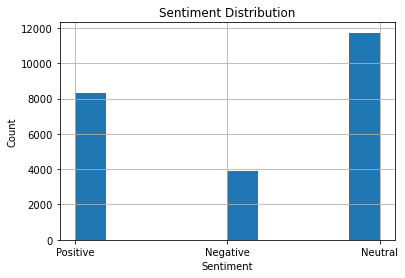

In [11]:
# Histogram

df['Sentiment'].hist()
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

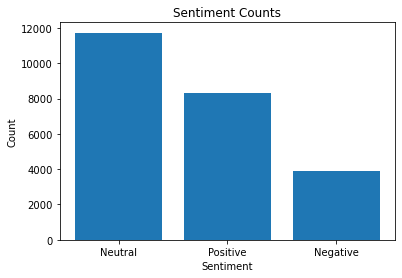

In [12]:
# Bar Chart

sentiment_counts = df['Sentiment'].value_counts()
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.title('Sentiment Counts')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

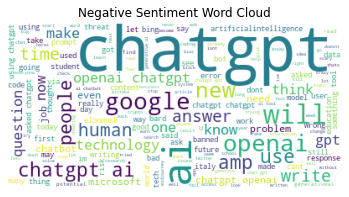

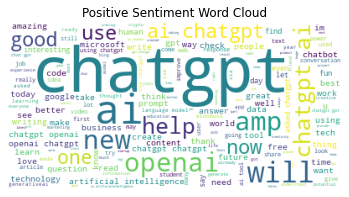

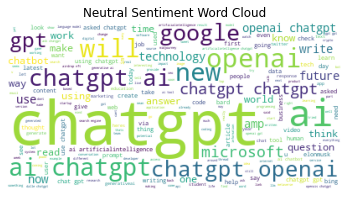

In [13]:
# Word Cloud

negative_tweets = df[df['Sentiment'] == 'Negative']['Tweet']
positive_tweets = df[df['Sentiment'] == 'Positive']['Tweet']
neutral_tweets = df[df['Sentiment'] == 'Neutral']['Tweet']

negative_wordcloud = WordCloud(background_color='white').generate(' '.join(negative_tweets))
positive_wordcloud = WordCloud(background_color='white').generate(' '.join(positive_tweets))
neutral_wordcloud = WordCloud(background_color='white').generate(' '.join(neutral_tweets))

plt.imshow(negative_wordcloud)
plt.axis('off')
plt.title('Negative Sentiment Word Cloud')
plt.show()

plt.imshow(positive_wordcloud)
plt.axis('off')
plt.title('Positive Sentiment Word Cloud')
plt.show()

plt.imshow(neutral_wordcloud)
plt.axis('off')
plt.title('Neutral Sentiment Word Cloud')
plt.show()

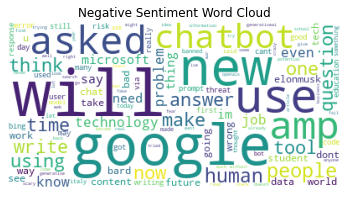

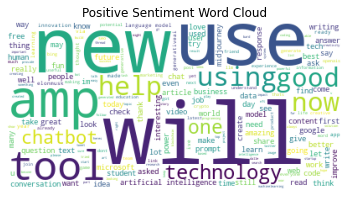

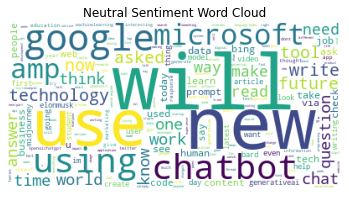

In [14]:
# Removing some additional words from the Word Cloud

custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['gpt', 'openai', 'chatgpt', 'ai', 'artificial intelligence', 'artificialintelligence'])

negative_wordcloud = WordCloud(stopwords=custom_stopwords, background_color='white').generate(' '.join(negative_tweets))
positive_wordcloud = WordCloud(stopwords=custom_stopwords, background_color='white').generate(' '.join(positive_tweets))
neutral_wordcloud = WordCloud(stopwords=custom_stopwords, background_color='white').generate(' '.join(neutral_tweets))

plt.imshow(negative_wordcloud)
plt.axis('off')
plt.title('Negative Sentiment Word Cloud')
plt.show()

plt.imshow(positive_wordcloud)
plt.axis('off')
plt.title('Positive Sentiment Word Cloud')
plt.show()

plt.imshow(neutral_wordcloud)
plt.axis('off')
plt.title('Neutral Sentiment Word Cloud')
plt.show()

In [15]:
# Here is a simple list of 100 tweets from each Sentiment class
# I wanted to be able to see and determine topics by eye

for sentiment in ['Positive', 'Neutral', 'Negative']:
    print(f"First 100 tweets for {sentiment} sentiment:")
    sentiment_df = df[df['Sentiment'] == sentiment]
    for i, tweet in enumerate(sentiment_df['Tweet'][:100]):
        print(f"{i+1}. {tweet}")
    print('\n')

First 100 tweets for Positive sentiment:
1. excited to share my first tweet as chatgpt a language model from openai looking forward to helping with natural language processing tasks and having some fun conversations httpstconzmlpgq
2. i for one welcome our ai overlords  hacktheplanet hackers chatgpt httpstcohbidpudsy
3. rtmannjr even the chatgpt   knows ranked choice voting is a good idea httpstcofplrmjmry
4. its time to pay attention to ai chatgpt amp beyond
httpstcoxkigabk ai python video artificialintelligence cisco hacking like code chatgpt coding chat openai research intelligence scriptwriting future elonmuskmsftalum msftgamedev microsoftalumni
5. ai apologizes to me thank you chatgptyour apology is accepted
civilwar history httpstcoryhxqrg
6. this morning i used chatgpt to recall glad strategies i was presented almost  years ago so i can outline strategically amp listen for the parts i need more support with and personalize my learning httpstcowcjianubnr
7. was at an event today 

In [18]:
# Moving the above information to a text file

if not os.path.exists('output'):
    os.makedirs('output')

for sentiment in ['Positive', 'Neutral', 'Negative']:
    with open(f"output/{sentiment}_tweets.txt", 'w', encoding='utf-8') as f:
        for i, tweet in enumerate(df[df['Sentiment'] == sentiment]['Tweet'][:100]):
            f.write(f"Tweet {i+1}: {tweet}\n\n")


## The following is an attempt to determine popular topics (code generated by GPT)

In [16]:
# Load lemmatizer
lemmatizer = WordNetLemmatizer()

# Define function to extract topics
def extract_topics(tweet):
    # Tokenize tweet into sentences and then words
    sentences = sent_tokenize(tweet)
    words = [word_tokenize(sentence) for sentence in sentences]
    
    # Lemmatize words and remove stopwords
    words = [lemmatizer.lemmatize(word.lower()) for sentence in words for word in sentence if word.lower() not in stop_words]
    
    return words

# Get the most common topics in each sentiment class
for sentiment in ['Positive', 'Neutral', 'Negative']:
    print(f"Top 5 topics for {sentiment} tweets:")
    sentiment_df = df[df['Sentiment'] == sentiment]
    topics = []
    for tweet in sentiment_df['Tweet']:
        topics.extend(extract_topics(tweet))
    topic_counts = Counter(topics)
    # Exclude certain topics from the list
    excluded_topics = ['chatgpt', 'ai', 'openai', 'chatbots', 'artificialintelligence', 'gpt', 'google']
    for topic, count in topic_counts.most_common(5):
        if topic.lower() not in excluded_topics:
            print(f"{topic}: {count}")
    print('\n')


Top 5 topics for Positive tweets:
like: 1038


Top 5 topics for Neutral tweets:


Top 5 topics for Negative tweets:




### NOTE: I am struggling to generate actual topics